# Week 3 - Linear Models and Efficient Computation with Kernels

## 🎯 Learning goals

1. Understand how kernel methods enable efficient computation for problems with more features than samples

2. Apply precomputed kernels using sklearn to solve a practical problem: perform brain decoding using functional Magnetic Images (fMRI) data

3. Understand the relationship between to the primal and dual formulations in kernel methods

4. Learn how to work with functional Magnetic Ressonance Imaging (fMRI) data. For information about fMRI check: https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging

### Most common use case of Kernels
Kernels can help machine learning models learn nonlinear decision boundaries by mapping input data into a higher dimensional feature space. This allows algorithms like support vector machines (SVMs) to find nonlinear boundaries in the input space to classify data. However, using kernels can be also a computational efficient way to train kernel models (e.g. SVMs) when the number of features is higher than the sample size.

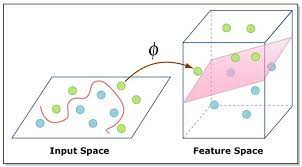

## 📍 Haxby fMRI dataset

- The Haxby study investigated face and object representation in human ventral temporal cortex
- The study consisted of 6 subjects passively viewing greyscale images of eight object categories (eg houses, cats, faces), grouped in 24s blocks separated by rest periods
- The study showed the images for 500ms and was followed by a 1500ms inter-stimulus interval, whilst taking a full-brain fMRI.
- The goal is to see whether you can decode what kind of image the person was looking at from patterns of brain activity in the visual cortex.
- More information can be found in the original study: Haxby, J., Gobbini, M., Furey, M., Ishai, A., Schouten, J., and Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. Science 293, 2425–2430: https://www.science.org/doi/10.1126/science.1063736

### Downloading dataset

We will use `nilearn` a python wrapper around `scikit-learn` that provides useful visualisation and statistical, ML tools for brain volume analysis.

The `nilearn.datasets.fetch_haxby` function will download the Haxby dataset if not present on the disk, in the nilearn data directory. It can take a while to download about 310 MB of data from the Internet.

In [ ]:
%pip install scikit-learn==1.7.2 matplotlib==3.10.8 pandas==2.3.3 seaborn==0.13.2 nilearn==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from nilearn import datasets

# Fetch Haxby dataset with stimuli
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby(fetch_stimuli=True)

# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print(f"First subject functional nifti images (4D) are at: {fmri_filename}")


[fetch_haxby] Added README.md to /root/nilearn_data

[fetch_haxby] Dataset created in /root/nilearn_data/haxby2001

[fetch_haxby] Downloading data from https://www.nitrc.org/frs/download.php/7868/mask.nii.gz ...

[fetch_haxby]  ...done. (0 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/MD5SUMS ...

[fetch_haxby]  ...done. (0 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/subj2-2010.01.14.tar.gz ...

[fetch_haxby] Downloaded 61022208 of 291168628 bytes (21.0%%,    3.8s remaining)

[fetch_haxby] Downloaded 94740480 of 291168628 bytes (32.5%%,    4.2s remaining)

[fetch_haxby] Downloaded 136282112 of 291168628 bytes (46.8%%,    3.4s remaining)

[fetch_haxby] Downloaded 183967744 of 291168628 bytes (63.2%%,    2.3s remaining)

[fetch_haxby] Downloaded 260562944 of 291168628 bytes (89.5%%,    0.6s remaining)

[fetch_haxby]  ...done. (6 seconds, 0 min)

[fetch_haxby] Extracting data from 
/root/nilearn_data/haxby2001/9cabe068089e791ef0c5fe930fc20e30/subj2-2010.01.14.tar.gz...

[fetch_haxby] .. done.

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/stimuli-2010.01.14.tar.gz ...

[fetch_haxby]  ...done. (0 seconds, 0 min)

[fetch_haxby] Extracting data from 
/root/nilearn_data/haxby2001/ee9e0d5a40146477e9197f0d13da9b32/stimuli-2010.01.14.tar.gz...

[fetch_haxby] .. done.

First subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj2/bold.nii.gz


### Visualizing the fMRI volume

One way to visualize a fMRI volume is using `nilearn.plotting.plot_epi.` We will visualize the previously fetched fMRI data from Haxby dataset.

Because fMRI data are 4D (they consist of many 3D EPI images acquired over time - dimensions are thus (x,y,z,t)), we cannot plot them directly using nilearn.plotting.plot_epi (which accepts just 3D input). Here we are using `nilearn.image.mean_img` to extract a single 3D EPI image from the fMRI data.



> Note: the plot is interactive, so you can scroll through the brain and look at different slices!



Mean image dimensionality (40, 64, 64)



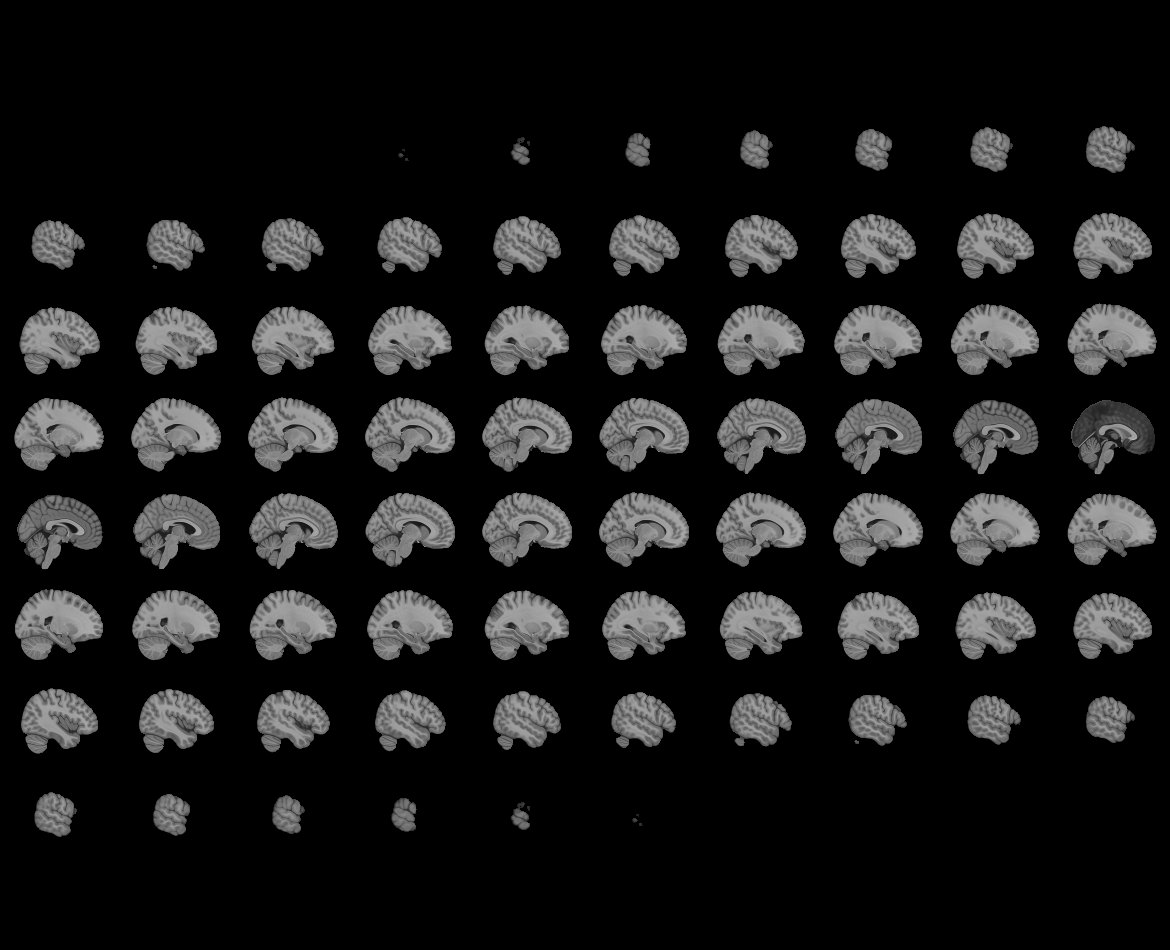
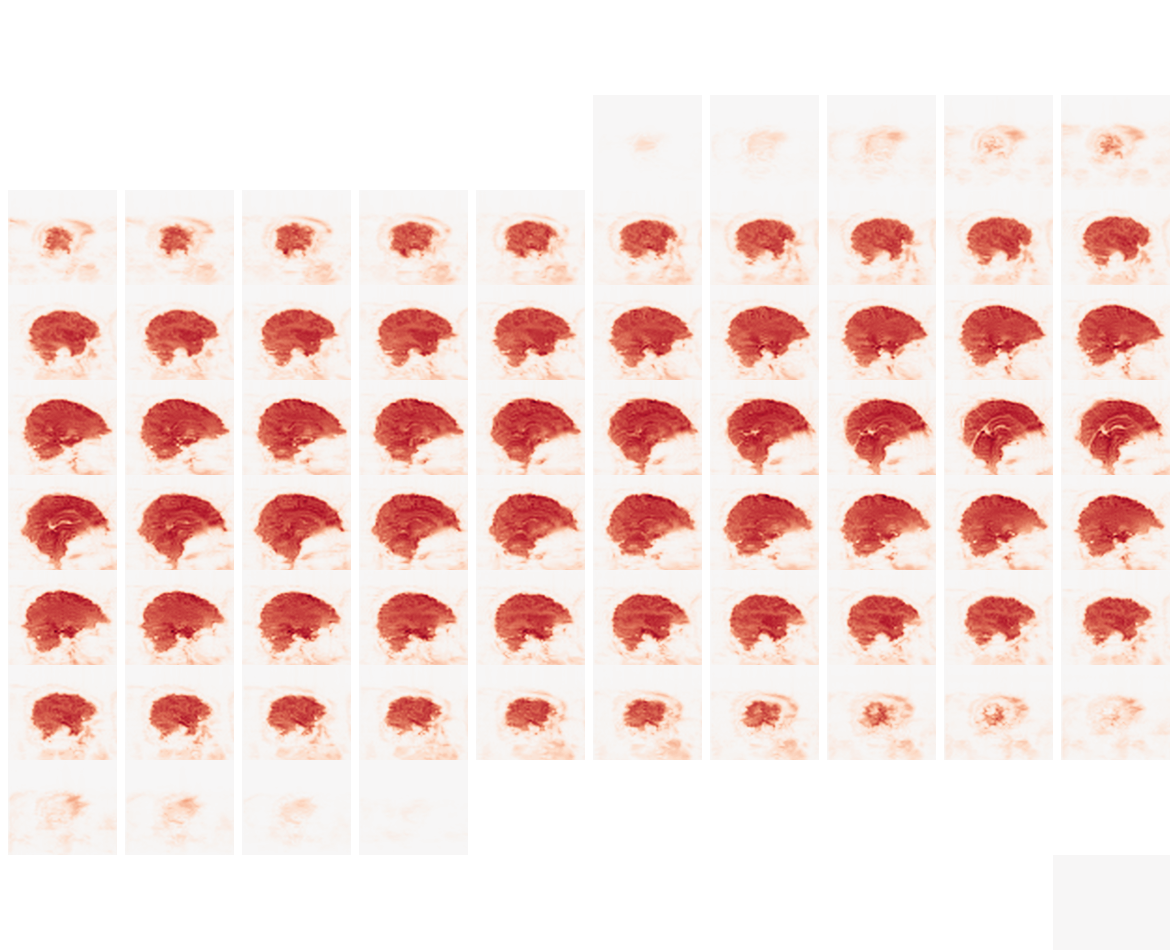

In [ ]:
from nilearn import plotting
from nilearn.image import mean_img
import warnings
warnings.filterwarnings('ignore')

# Inspect volume dimensionlity (size of image)
print(f'Mean image dimensionality {mean_img(fmri_filename).shape}')

# Plot an fMRI volume
plotting.view_img(mean_img(fmri_filename), threshold=None)

### Visualizing the MRI volume

The Haxby dataset also contains anatomical MRI, through which we can visualise the different brain structures.


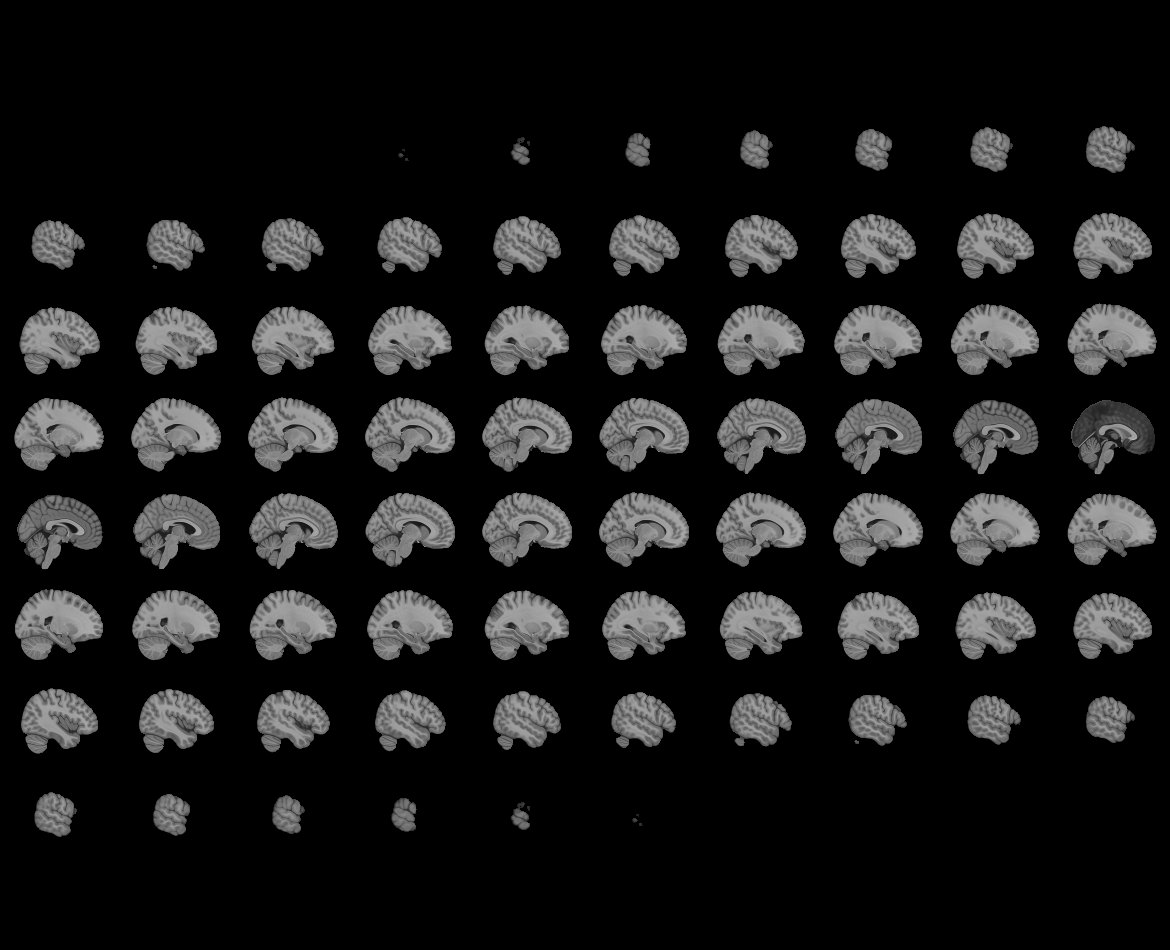
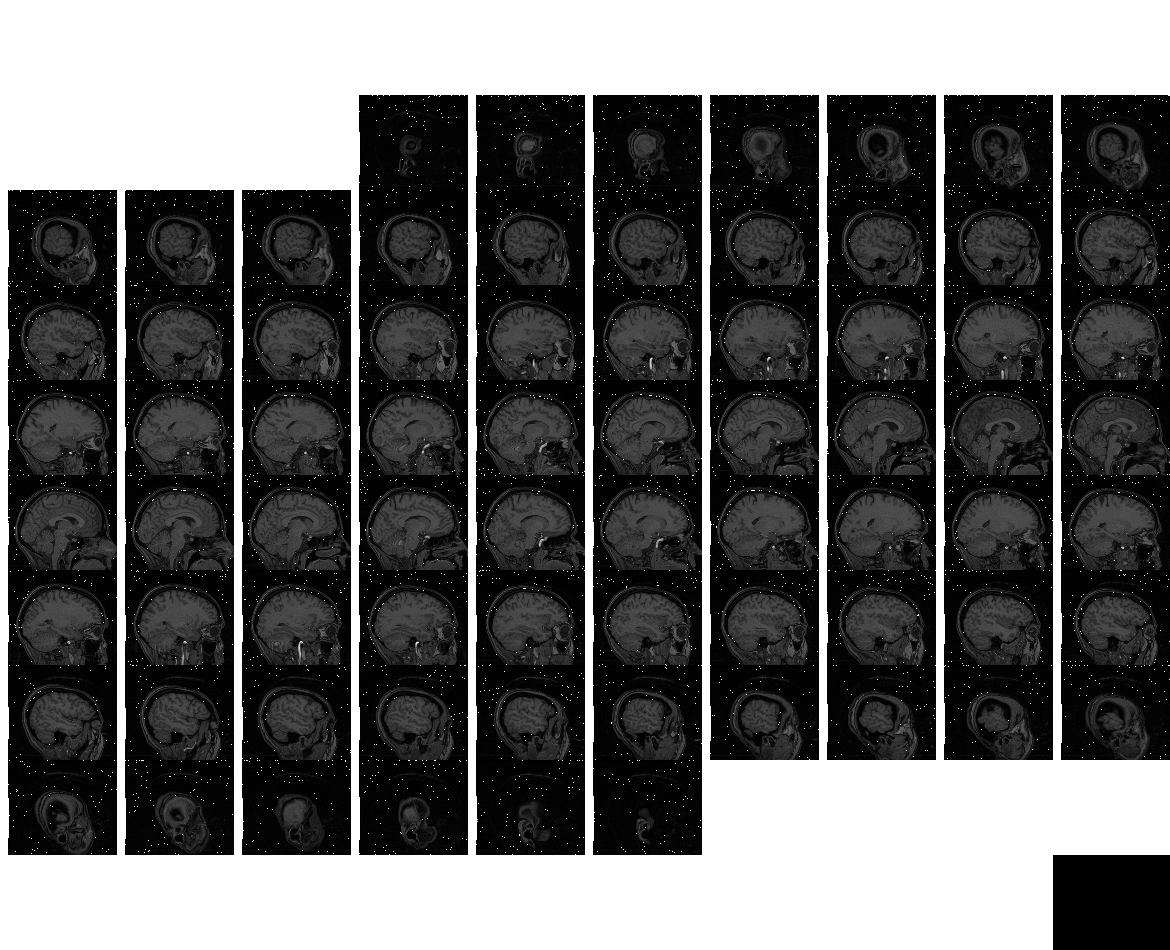

In [ ]:
# Anatomical MRI file
anat_filename = haxby_dataset.anat[0]

# Visualize the anatomical image
plotting.view_img(anat_filename, symmetric_cmap=False, cmap='Greys_r', colorbar=False)

### Applying a **brain** mask to get data of interest (visual processing area of the brain)

These are some really lovely images, but for machine learning we need matrices to work with the actual data. If we want to use sklearn we will need to transform the Nifti images into a **data matrix**. For the first model we will only use voxels within **Ventral Temporal (VT) cortex** which is a visual processing area. A mask of the VT coming from the Haxby study is available. We have to define a brain mask filename.

**Why not use the whole brain?** We apply a mask because whole-brain fMRI is huge, and most voxels are either irrelevant to the task or add noise. Masking is a way to select a subset of voxels (features) so the machine learning problem becomes more tractable and interpretable. In this case, we select voxels that we expect to contain strong visual category information, i.e., the VT.

/root/nilearn_data/haxby2001/subj2/mask4_vt.nii.gz


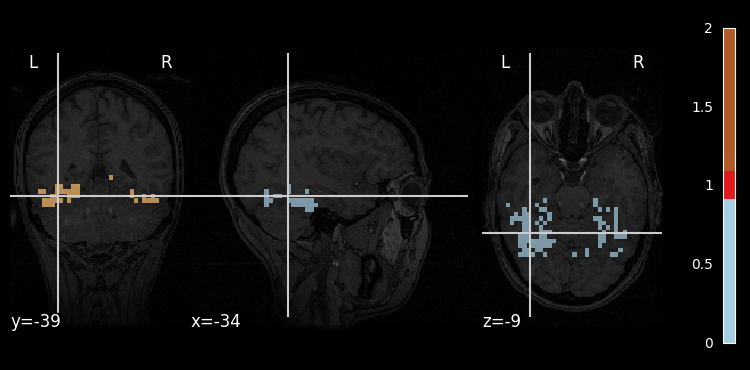

In [ ]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0], cmap="Paired")

print(mask_filename)

### Loading the **labels**

Now we can load the labels that are stored in a CSV file, separated by spaces.

We use pandas to load them in an array.


The task was a visual-recognition task, and the labels denote the experimental condition (the type of object presented to the subject). **Each label tells us what category the subject was viewing** at that moment (e.g. faces, houses, cats, etc.). **This is what we are going to try to predict from the fMRI data.**

In [ ]:
# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=" ")

# Enable viewing of all rows of pandas dataframe
pd.set_option('display.max_rows', None)
print(behavioral)

            labels  chunks
0             rest       0
1             rest       0
2             rest       0
3             rest       0
4             rest       0
5             rest       0
6         scissors       0
7         scissors       0
8         scissors       0
9         scissors       0
10        scissors       0
11        scissors       0
12        scissors       0
13        scissors       0
14        scissors       0
15            rest       0
16            rest       0
17            rest       0
18            rest       0
19            rest       0
20            rest       0
21            face       0
22            face       0
23            face       0
24            face       0
25            face       0
26            face       0
27            face       0
28            face       0
29            face       0
30            rest       0
31            rest       0
32            rest       0
33            rest       0
34            rest       0
35             cat       0
3

As we can see from the targets above, the experiment contains many conditions. As a consequence, the dataset is quite large. Not all of this data is of interest to us for decoding, so **we will keep only fMRI data corresponding to faces or houses**. We create a **temporal mask** of the samples belonging to these two conditions; this mask is then applied to the fMRI data to restrict the classification to the face vs house discrimination.

**Note:** Previously, we applied a **spatial mask** to keep only the VT cortex in the fMRI scans. Since it's a spatial mask, it is applied across the first 3 dimensions of the fMRI data, i.e. (x, y, z). The fourth dimension (t) is left untouched. This time, we apply a **temporal mask** to keep only the timepoints where the subject was shown houses and faces. Thus, to select the corresponding fMRI data, we apply a temporal mask on the time dimension (t). Here, (x, y, z) are left untouched.

The **input data will become much smaller** (i.e. we will have fewer samples/timepoints).

> How many time points correspond to our stimuli of interest?

In [ ]:
from nilearn.image import index_img, smooth_img
import numpy as np

condition_mask = behavioral["labels"].isin(["face", "house"])
# The data is in one single large 4D image
fmri_niimgs = index_img(fmri_filename, condition_mask)

# Reading mask Nifti from filename path
fmri_niimgs_mask = smooth_img(mask_filename, None)


# Checking dimensionality of data
print(f'4D data dimensionality (3 spatial dimensions + time) {fmri_niimgs.shape}')
print(f'mask dimensionality {fmri_niimgs_mask.shape}')


4D data dimensionality (3 spatial dimensions + time) (40, 64, 64, 216)
mask dimensionality (40, 64, 64)


**Viewing the stimuli images**

Now that we have selected a sample of labels (stimuli), we can visualise them.

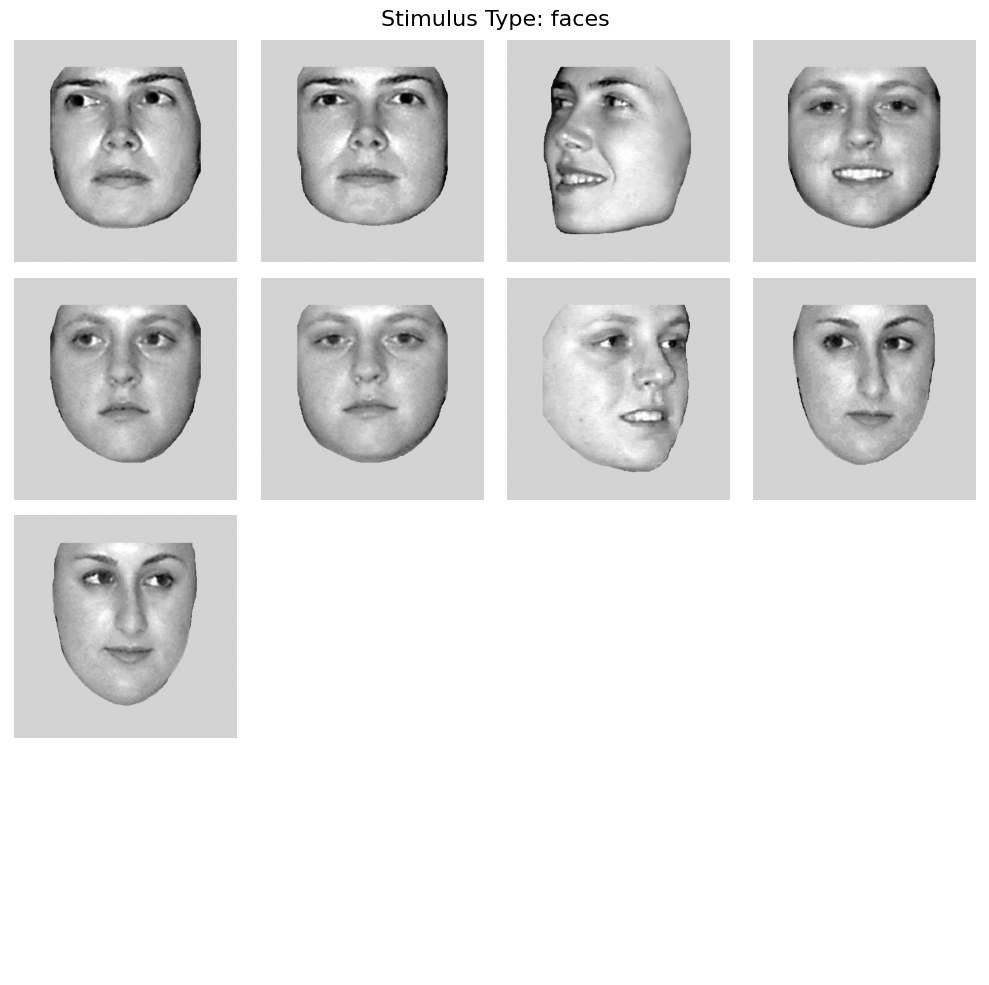

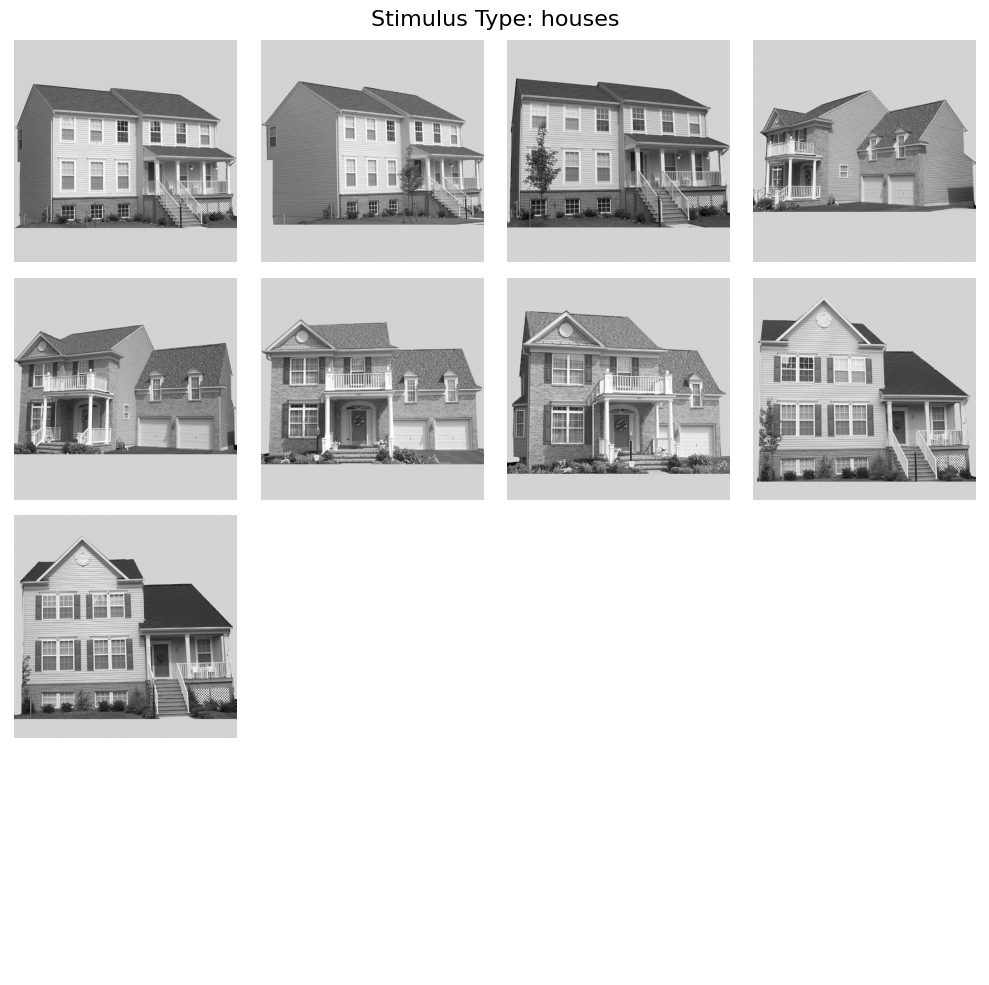

In [ ]:
from nilearn.plotting import show

# Stimulus information from the Haxby dataset
stimulus_information = haxby_dataset.stimuli

# Filter the behavioral data using the same condition mask
filtered_behavioral = behavioral[condition_mask]

# Visualize stimuli corresponding to the filtered conditions
for stim_type in ["faces", "houses"]:  # Focus only on "face" and "house"
    file_names = stimulus_information[stim_type]

    # Align stimuli with the filtered behavioral data indices
    filtered_file_names = [
        file_names[i] for i in filtered_behavioral.index if i < len(file_names)
    ]

    # Display up to 16 stimuli images for the current type
    filtered_file_names = filtered_file_names[:16]
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(f"Stimulus Type: {stim_type}", fontsize=16)

    for img_path, ax in zip(filtered_file_names, axes.ravel()):
        # Read and display the image
        img = plt.imread(img_path)
        ax.imshow(img, cmap=plt.cm.gray)

    # Turn off axes for all subplots
    for ax in axes.ravel():
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show()

**Stimuli vs time plot**
<br>Visualise the distribution of the two stimuli of interest during the experiment. Each point represents a particular label (face or house) that was shown at a particular time during the experiment. For each stimuli, an fMRI scan was acquired.




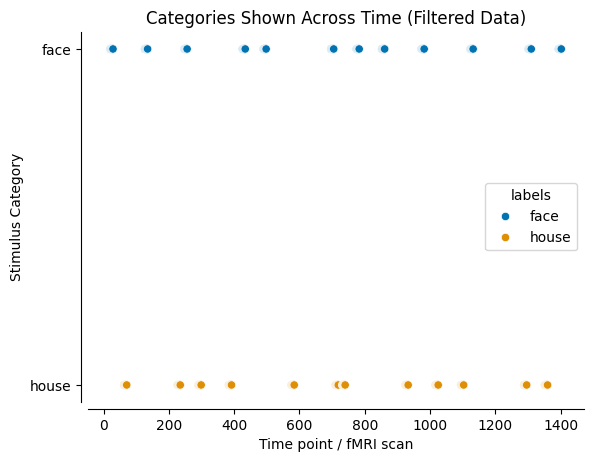

In [ ]:
# Use the filtered behavioral data
filtered_behavioral = behavioral[condition_mask]

# Create the scatter plot
ax = sns.scatterplot(
    x=filtered_behavioral.index,  # Time points (indices)
    y=filtered_behavioral["labels"],  # Labels ("face", "house")
    hue=filtered_behavioral["labels"],  # Color by label
    legend="full",  # Show legend for labels
    palette="colorblind"  # Use a colorblind-friendly palette
)

# Customize the plot
plt.title("Categories Shown Across Time (Filtered Data)")
ax.set_xlabel("Time point / fMRI scan")
ax.set_ylabel("Stimulus Category")
sns.despine(offset=5)  # Remove spines for a clean look

plt.show()

### Converting the images into a data matrix and applying the spatial (brain) mask

Reshape the data to prepare for a machine learning model i.e., get a data matrix in a 2D format: **features x samples**.


> Which dimension was flattened (spatial or temporal)? <br>


> What do the new dimensions correspond to?

In [ ]:
# Convert the NIfTI image to a numpy array
data = fmri_niimgs.get_fdata()

# Reshape the data
# -1 will automatically calculate the size of the first dimension
reshaped_data = data.reshape(-1, data.shape[-1])

print(reshaped_data.shape)

Reshape the brain mask to match the new data shape

In [ ]:
data_mask = fmri_niimgs_mask.get_fdata()
reshaped_mask = data_mask.reshape(-1)

print(reshaped_mask.shape)

**Count non-zero elements in the mask**
<br>We use a brain mask to include only the part of the brain responsible for visual processing.

> How many data points does this leave us with in each fMRI scan, and how does this affect the number of features we will use in our model?

In [ ]:
print(reshaped_mask.sum())

**Sanity check**
<br>Try reshaping the reshaped data and mask to the original shape

In [ ]:
# reshaping to original

original_data_shape = (40, 64, 64, 216)  # Replace with the actual original shape
original_mask_shape = (40, 64, 64)

# Reshape data back to the original shape
data_original_shape = reshaped_data.reshape(original_data_shape)

# Reshape mask back to the original shape
mask_original_shape = reshaped_mask.reshape(original_mask_shape)

Check if the un-reshaped data and mask match the original

In [ ]:
# check if original and un-reshape reshaped match
print(np.array_equal(data, data_original_shape))

# check if original and un-reshape reshaped match
print(np.array_equal(data_mask, mask_original_shape))

**Filter the data**
<br>Now that we have reshaped the data and brain mask, and checked them, we can apply the mask to our data to only include our brain region of interest (VT cortex).
<br>We do this by keeping only the data elements that correspond to non-zero values in the brain mask.
<br>We also create a matrix containing the position of the non-zero elements from the brain mask to keep track of the location of our brain regions of interest.

> What do you expect the resulting data shape to be?

In [ ]:
# Apply the mask to the data
filtered_data = reshaped_data[reshaped_mask != 0]

# To get the index positions of the non-zero elements in the mask
# np.nonzero returns a tuple - take the first element
nonzero_indices = np.nonzero(reshaped_mask)[0]

# Now, 'filtered_data' contains only the rows with non-zero mask elements
# and 'nonzero_indices' contains the indices of these non-zero elements

# If you need an index matrix with the same shape as the filtered_matrix
# where each row is filled with the corresponding index from nonzero_indices
index_matrix = np.tile(nonzero_indices[:, np.newaxis], (1, filtered_data.shape[1]))

print(filtered_data.shape)
print(nonzero_indices)

We apply the same **temporal mask** that we applied to the fMRI data earlier to the targets (i.e., get only targets corresponding to "house" or "face").
<br>This is not the brain mask, but the `condition_mask` used to select our desired labels.

In [ ]:
conditions = behavioral["labels"][condition_mask]
# Convert to numpy array
conditions = conditions.values
print(conditions.shape)
print(conditions)

**Encode the labels**
<br>Right now, the labels are in string format i.e., 'houses', 'faces'. To make them suitable for a ML task, we need to convert them to numerical values.
<br>**Task:** create a vector of binary labels (`y`).  

In [ ]:
# add code to convert conditions to binary labels y

# Example: convert 'face' to 1 and 'house' to 0
y = # Your code here...

Check your data shape.

In [ ]:
print(filtered_data.shape)
print(y.shape)

# 🧑‍💻 TASK 1: Train an SVM to decode the labels from the fMRI data


## 1.1 Split the `filtered_data` into train and test (leaving the last 36 examples for test)

Because fMRI timepoints are **not independent** (closeby samples are highly correlated, and the experiment is block-based), we should not randomly shuffle the data before splitting. Instead, we use a time-based split: we keep the last 36 examples as a held-out test set, and use the remaining examples for training. This reduces data leakage from temporally close samples.

**Why 36?** One block is 9 fMRI volumes (timepoints) so we keep 3-4 (here 4) blocks for testing. But you can change this number if you like, just be mindful of data leakage.

Create train and test sets for the classification model.

> How is the balance between features (p) and samples (N)?

In [ ]:
# The number of features is the first dimension of filtered_data, and the number of samples is the second dimension
num_samples = filtered_data.shape[1]

test_size = 36   # Reserve the last 36 samples for testing

# Calculate the index where the test set starts
split_index = num_samples - test_size

# Split the data along the second dimension (time)
X_train = filtered_data[:, :split_index]
X_test  = filtered_data[:, split_index:]

y_train = y[:split_index]
y_test  = y[split_index:]

# Transpose X_train and X_test so that each row represents a sample
X_train = X_train.T
X_test  = X_test.T

# Confirm the dimensions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


## 1.2 Do a **cross-validation** on the training set to optimize the SVM hyper-parameters and after apply the SVM model with the optimal hyper-parameter to the test data. Print the mean and the standard deviation of the CV score, the best hyperparameter and the test score

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

param_grid = {
    'C': [None],  # Example values
    'gamma': [None],
    'kernel': ['rbf', 'linear']
}

# Create a GridSearchCV object with an SVM classifier
grid = GridSearchCV(None)  # 5-fold cross-validation

# Time the grid search
start_time = time.time()

# Perform grid search
grid.None

# Measure and print the time taken
time_taken = time.time() - start_time
print("Time taken for GridSearchCV with regular kernels: {:.2f} seconds".format(time_taken))


# Print the results
print("Mean CV Score: ", grid.cv_results_['mean_test_score'][grid.best_index_])
print("Std Dev of CV Score: ", grid.cv_results_['std_test_score'][grid.best_index_])
print("Best Hyperparameters: ", grid.best_params_)

# Evaluate on the test set
y_pred = grid.None
test_score = accuracy_score(None)
print("Test Score: ", test_score)


# Predict on the test set
y_pred = grid.None

# Print predictions
print("Predictions on the test set:", y_pred)

# Calculate and print the accuracy score
test_accuracy = accuracy_score(None)
print("Final Test Accuracy:", test_accuracy)

## 1.3 Inspect the SVM weights

Let's inspect and display the SVC model' weights by turning them into a nifti image.

First we want to retrieve the SVM weights.

In [ ]:
# add the code here to show the coefficients

# Make sure your best model is using a linear kernel
print("kernel:", grid.best_params_['kernel'])

# If the kernel is linear, retrieve the weights
if grid.None == 'linear':
    # The best estimator in your grid search
    best_svm = grid.None

    # Retrieve the SVM weights (coefficients)
    svm_weights = best_svm.None

    # Print the weights
    print("SVM Weights:", svm_weights)
else:
    print("SVM weights are not interpretable for non-linear kernels.")


It’s an array with only one coefficient per voxel (data point).

In [ ]:
# add code to print the coef. shape
print("Shape of SVM Coefficients:", svm_weights.shape)

To get the Nifti image of these coefficients we need to convert the coef. to 3D and create a Nifti image

In [ ]:
print(type(data_mask))

In [ ]:
# add code here

from nilearn.image import new_img_like

# Initialize a 3D array with zeros
# Assume original_shape is the shape of the original 3D brain image
coef_3d = coef_3d = np.None

# Map the coefficients back to their original voxel locations
coef_3d.flat[nonzero_indices] = svm_weights

print(coef_3d.shape)


# Create a Nifti image
coef_img = new_img_like(fmri_niimgs_mask, coef_3d)

# coef_img is now a Nifti image of the SVM coefficients

## 1.4 Plotting the SVM weights
We can plot the weights, using the subject’s anatomical MRI as a background.

In [ ]:
from nilearn import plotting

# Assuming coef_img is the Nifti image containing your SVM weights
# and haxby_dataset.anat[0] is the path to the anatomical image

# Plot the SVM weights
plotting.plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
                       display_mode='ortho',
                       title='SVM Weights',
                       cut_coords=(28, -34, -22),
                       cmap='coolwarm')

# Show the plot
plotting.show()


# 👩‍💻 TASK 2: Train an SVM with pre-computed kernel for computational efficiency

For the second task we will use the **whole brain** voxels as features. We will start by creating a whole brain mask to include all voxels within the brain.





In [ ]:
from nilearn.maskers import NiftiMasker
from nilearn.plotting import plot_epi, plot_roi, show

masker = NiftiMasker(mask_strategy="epi")
masker.fit(fmri_filename)

whole_brain_mask = masker.mask_img_

# Let's visualize the whole brain mask, using the subject's anatomical image as a
# background
plotting.plot_roi(whole_brain_mask, bg_img=haxby_dataset.anat[0], cmap="Paired")

# Checking dimensionality of the mask
print(f'Mask dimensionality {whole_brain_mask.shape}')

Reshape whole brain mask


In [ ]:
# Convert the NIfTI image to a numpy array
wb_mask = whole_brain_mask.get_fdata()
reshaped_wb_mask = wb_mask.reshape(None)

# Reshape the data
print(reshaped_wb_mask.shape)

# print(reshaped_whole_brain_mask.shape)

**Size of whole brain mask**

Count non-zero elements in the new mask, which corresponds to the number of voxels within the whole brain mask

> How many data points are in the mask now? Compare this to the size of the VT mask used before.

In [ ]:
print(reshaped_wb_mask.None)

Now, filter the data using the mask to keep only the brain.

In [ ]:
# Apply the whole mask to the data
filtered_wb_data = reshaped_data[None]

# To get the index positions of the non-zero elements in the mask
# np.nonzero returns a tuple - take the first element
nonzero_wb_indices = np.None

# Now, 'filtered_data' contains only the rows with non-zero mask elements
# and 'nonzero_indices' contains the indices of these non-zero elements

# If you need an index matrix with the same shape as the filtered_matrix
# where each row is filled with the corresponding index from nonzero_indices
index_wb_matrix = np.tile(nonzero_indices[:, np.newaxis], (1, filtered_wb_data.shape[1]))

print(filtered_wb_data.shape)

Now we can create a data matrix using the whole brain mask and compute linear kernel from the data matrix $K = X'X$, and will repeat task 1 training the SVM using the option of a **pre-computed kernel**.

https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#sphx-glr-auto-examples-svm-plot-custom-kernel-py

## 2.1 Set up test/train split like in task 1

> How do the number of features (p) compare to the sample size (N) here?

In [ ]:
# The number of features is the first dimension of filtered_data, and the number of samples is the second dimension
num_samples = filtered_wb_data.shape[1]

test_size = 36   # Reserve the last 36 samples for testing

# Calculate the index where the test set starts
split_index = num_samples - test_size

# Split the data along the second dimension (time)
X_train = filtered_wb_data[:, :split_index]
X_test  = filtered_wb_data[:, split_index:]

y_train = y[:split_index]
y_test  = y[split_index:]

# Transpose X_train and X_test so that each row represents a sample
X_train = X_train.T
X_test  = X_test.T

# Confirm the dimensions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)


Apply a **linear kernel** to your data.

> What is the resulting data dimensionality after the kernel trick?

> How does it compare to the original data?

In [ ]:
def linear_kernel(X,Y):
#     print(X.shape,Y.shape)
#     M = np.array([[2, 0], [0, 1.0]])
    return None

X_train_kernel = linear_kernel(None)
X_test_kernel = linear_kernel(None)

# Check the kernel and the data dimensionality
print("X_train_kernel shape:", X_train_kernel.shape)
print("X_train shape:", X_train.shape)
print("X_test_kernel shape:", X_test_kernel.shape)
print("X_test shape:", X_test.shape)

## 2.3 Train SVM with precomputed Kernel on the entire original dataset ie `reshaped_data` rather than the masked reduced features dataset ie `filtered_data`


🤔 What can we learn from the time differences of GridSearchCV using regular Kernels (task 1) vs a precomputed Kernel (task 2)?

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

# Define the parameter grid for hyperparameter tuning
param_grid_precomputed = {
    'C': [0.1, 1, 10, 100],  # Example values
    #    'gamma': [1, 0.1, 0.01, 0.001], # Do we need gamma? No since it's hyperparameter for certain kernel function like RBF
     'kernel': ['precomputed']
}

# Create a GridSearchCV object for the precomputed kernel
grid_precomputed = GridSearchCV(SVC(), param_grid_precomputed, refit=True, verbose=2, cv=5)

# Time the grid search for the precomputed kernel
start_time_precomputed = time.time()

# Perform grid search
grid_precomputed.None

# Measure and print the time taken
time_taken_precomputed = time.time() - start_time_precomputed
print("Time taken for GridSearchCV with precomputed kernel: {:.2f} seconds".format(time_taken_precomputed))


# Print the results
print("Mean CV Score: ", grid_precomputed.cv_results_['mean_test_score'][grid.best_index_])
print("Std Dev of CV Score: ", grid_precomputed.cv_results_['std_test_score'][grid.best_index_])
print("Best Hyperparameters: ", grid_precomputed.best_params_)

# Evaluate on the test set

y_pred = grid_precomputed.predict(X_test_kernel)
test_score = accuracy_score(y_test, y_pred)
print("Test Score: ", test_score)




# Mapping the dual weights back to the primal

In order to visualize the weights in the input space we need to **map the SVM dual coefficients back to the primal weights**.

In [ ]:
# Add code here
best_svm = grid_precomputed.None

# Retrieve the SVM weights (coefficients)
support_index = best_svm.support_
svm_alpha = best_svm.None

Compute the primal weights from the dual coefficients: a weighted sum of the support vectors.

In [ ]:
precomputed_svm_weight = np.zeros(X_train.shape[1])
for i in range(len(support_index)):
    precomputed_svm_weight += X_train[support_index[i]]*svm_alpha[0][i]

Check the size of the resulting weights.

> What weight vector size do you expect?

In [ ]:
precomputed_svm_weight.shape

Once we have the primal weights we can now create a nifti image using the same procedure as before

In [ ]:
# Add code here

from nilearn.image import new_img_like

# Initialize a 3D array with zeros
# Assume original_shape is the shape of the original 3D brain image
coef_3d = coef_3d = np.None

# Map the coefficients back to their original voxel locations
coef_3d.flat[None] = precomputed_svm_weight

# print(coef_3d.shape)


# Create a Nifti image
coef_img = new_img_like(fmri_niimgs_mask, coef_3d)

# coef_img is now a Nifti image of the SVM coefficients

In [ ]:
# add code here
from nilearn import plotting

# Assuming coef_img is the Nifti image containing your SVM weights
# and haxby_dataset.anat[0] is the path to the anatomical image

# Plot the SVM weights
plotting.plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
                       display_mode='ortho',
                       title='SVM Weights',
                       cut_coords=(28, -34, -22),
                       cmap='coolwarm')

# Show the plot
plotting.show()
